## Toxic Comment Classification using 1-D CNN

In this notebook I will be using LSTM for Toxic Comment Classification. This notebook follows the same template as 1-D CNN but I will be using LSTM instead.  

### The Data 

The data consists of a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are
 - toxic
 - severe_toxic
 - obscene
 - threat 
 - insult
 - identity_hate 
 
The levels of toxicity are multiple labels that we need to classify. The link to data is given below 

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Here, I will be using pre-trained Glove word embeddings from Stanford which can be downloaded from the following link. 

http://nlp.stanford.edu/data/glove.6B.zip

### Basic Imports 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import LSTM,Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

### Constants 

In [2]:
MAX_SEQUENCE_LENGTH = 100

MAX_VOCAB_SIZE = 20000

EMBEDDING_DIM = 100 # pre-trained embeddings only come in specific sizes, so we can only use 50,100,200 or 300

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 128

EPOCHS = 5

### Loading Word Embeddings 

In [3]:
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.100d.txt'),encoding='utf8') as f:
  
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found {} word vectors.'.format(len(word2vec)))

Found 400000 word vectors.


### Loading Data

In [4]:
data_train = pd.read_csv('train.csv')

In [5]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
data_train.shape

(159571, 8)

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### Seprating comments from the data frame

In [8]:
comments = data_train['comment_text'].fillna('Dummy_Value').values

In [9]:
comments.shape

(159571,)

In [10]:
type(comments)

numpy.ndarray

### Creating labes for the multi-label classification 

In [11]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [12]:
targets = data_train[labels].values

In [13]:
# targets shape : (Num of Samples,Num of target labels)
targets.shape

(159571, 6)

### Printing out some information about the comments

In [14]:
print('Max Sentence Length : ', max(len(sentence) for sentence in  comments))

Max Sentence Length :  5000


In [15]:
print('Min Sentence Lenth :', min(len(sentence) for sentence in comments))

Min Sentence Lenth : 6


In [16]:
sorted_comments = sorted(len(sentensce) for sentensce in comments)
print('Median Sentence Lenth :', sorted_comments[len(sorted_comments)//2])

Median Sentence Lenth : 205


### Tokenizing 

In [17]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [18]:
tokenizer.fit_on_texts(comments)

In [19]:
sequences = tokenizer.texts_to_sequences(comments)

In [ ]:
# print("sequences:", sequences); exit(), please note: the data might just be too big for the Ipyton kernel to handle. 

In [20]:
print("Max sequence length:", max(len(s) for s in sequences))

Max sequence length: 1400


In [21]:
print("Max sequence length:", min(len(s) for s in sequences))

Max sequence length: 0


In [22]:
sorted_seq = sorted(len(s) for s in sequences)
print("Median sequence length:", sorted_seq[len(sorted_seq) // 2])

Median sequence length: 35


###  Word to Integer mapping

In [23]:
word2idx = tokenizer.word_index

In [24]:
print('Number of Unique tokens are : {}'.format(len(word2idx)) ) 

# We actually have more words than the MAX_VOCAB_SIZE!!

Number of Unique tokens are : 210337


### Padding 

In [25]:
pad_data = pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [26]:
# Note that the 0 axis is same as comments, just added a new padding dimension which is equal to MAX_SEQUENCE_LENGTH . 
# Padded tensor shape : (Num of Samples,MAX_SEQUENCE_LENGTH)

print('Shape of Padded Tensor: {}'.format(pad_data.shape)) 

Shape of Padded Tensor: (159571, 100)


### Prepare embedding matrix

In [27]:
# This truncates the word embeddings to MAX_VOCAB_SIZE, +1 is to take care of a little indexing problem.

# In Keras 0 is reserved just for padding, so the indexing starts at 1. 

# Since, python index starts at 0, that +1 takes care of any indexing miss matching. 

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) 

In [28]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [29]:
embedding_matrix.shape

# We have successfuly trucnated and created an embedding matrix of dimension (MAX_VOCAB_SIZE,EMBEDDING_DIM )
# Now we have to index it using the words from the pre-trained word2vec to create pre-trained embedding matrix 

(20000, 100)

In [30]:
for word,i in word2idx.items():
    
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        
        if embedding_vector is not None:
            
            # words not found in embedding index will be all zeros.
            
            embedding_matrix[i] = embedding_vector    

### Loading pre-trained word embeddings into an Embedding layer

In [31]:
embedding_layer = Embedding(input_dim=num_words,output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=False)

### Buiding the Model 

In [32]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))

x = embedding_layer(input_)

x = LSTM(units=20,return_sequences=True)(x)

x = GlobalMaxPooling1D()(x) # Grabs the maximum value from the entire seqence 

output = Dense(len(labels), activation='sigmoid')(x)

In [33]:
model = Model(input_,output)

In [34]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Training 

In [35]:
trained_model = model.fit(pad_data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 44s 341us/step - loss: 0.1523 - acc: 0.9586 - val_loss: 0.0793 - val_acc: 0.9749
Epoch 2/5
127656/127656 [==============================] - 43s 338us/step - loss: 0.0665 - acc: 0.9778 - val_loss: 0.0618 - val_acc: 0.9790
Epoch 3/5
127656/127656 [==============================] - 44s 346us/step - loss: 0.0575 - acc: 0.9801 - val_loss: 0.0564 - val_acc: 0.9800
Epoch 4/5
127656/127656 [==============================] - 43s 339us/step - loss: 0.0539 - acc: 0.9810 - val_loss: 0.0543 - val_acc: 0.9805
Epoch 5/5
127656/127656 [==============================] - 43s 337us/step - loss: 0.0517 - acc: 0.9816 - val_loss: 0.0528 - val_acc: 0.9810


### Plotting Accuracy

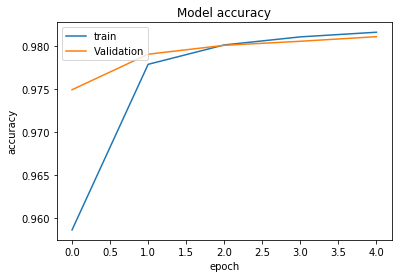

In [36]:
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

#### If we compare this with 1-D CNN we can already see how powerfull LSTM's are.  

### Plotting Loss

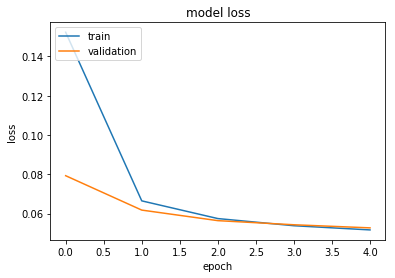

In [37]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

#### Further proof on the effectiveness of LSTM's 

### Plotting mean AUC over each label

In [38]:
pred = model.predict(pad_data)

In [39]:
auc_accuracy = []
for i in range(len(labels)):
    auc = roc_auc_score(targets[:,i], pred[:,i])
    auc_accuracy.append(auc)
print('Mean AUC score for all labels:',np.mean(auc_accuracy))

Mean AUC score for all labels: 0.9752725887471686


### Calculating Parameters 

In [40]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 20)           9680      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 2,009,806
Trainable params: 9,806
Non-trainable params: 2,000,000
_________________________________________________________________
None


The mean AUC score is slightly better that 1-D CNN but we also have to keep in mind the size of the model and training time. The 1-D CNN model had way more parameters than LSTM, still it took me less time to train 1-D CNN than the LSTM model with a single LSTM layer of 20 units. 

1-D CNN = Trainable params: 48,518: ; Training time per epoch : about 32 sec 

LSTM = Trainable params: 9,806 ; Training time per epoch : about 43 sec 

It also shows the effectiveness of LSTM in seqence models. The model performed better than 1-D CNN model even with only 1/5th of Trainable params.  